In [2]:
# Importing NumPy and the VPython functions that we need.
import numpy as np
from vpython import canvas, vector, color, sphere, rate, arrow, box, ring, cylinder, scene, label
import matplotlib.pyplot as plt

#Creates start height data
#No throttle limits
#100% throttle
#Just 1D vertical to start
## CREATING START HEIGHT DATA / SIMULATING DIFF SPEEDS

In [6]:
# Creating a canvas.
scene=canvas(width=800, height=400)
Ocean = box(pos=vector(0,-5,0),length=5000, height=10, width=5000, color=vector(0,0.8,1))

# Objects (based on 'just read the instructions' and falcon 9 full thrust block 5 first stage,
# all distances in METRES, ship deck is 3M above ocean level!)
# (https://en.wikipedia.org/wiki/Falcon_9_Full_Thrust#Rocket_specifications)

Ship = box(pos=vector(0,-3,0), length=90, width=50, height=6, color=vector(0.7,0.7,0.7))     #ship target at y=0 now
Ship_yring = ring(pos=vector(0,2.2,0),axis=vector(0,1,0), radius=10, thickness=1, color=vector(1,0.95,0))
Ship_wring = ring(pos=vector(0,2.2,0),axis=vector(0,1,0), radius=18, thickness=1, color=vector(1,1,1))
Rocket= cylinder(axis=vector(0,42.6,0), radius=1.83, color=vector(0.9,0.9,0.9),make_trail=True,
                 trail_type="points",trail_radius=10)
scene.camera.follow(Rocket)

#####THRUST######(Newtons at sea level, only 1 engine here for landing burn, doesn't include throttle up time)
Throttle=0.6
Thrust=Throttle*850000

################################################################################################ INIT CONDITIONS
#v=-517.8
#v=-650.0
#h=10000 

def BURN(v,h,mfrac):
    g=9.81
    BurnTime=0.
    
    EmptyMass=22200
    LandingPercent=mfrac  #amount of first stage fuel left over for landing burn             
    InitFuel=(LandingPercent*410900)
    InitMass=EmptyMass+InitFuel

    ################################################################################################ FORCES^^
    #####WEIGHT######

    #####AIR RESISTANCE######
    #From wikipedia (dry air density) less than 18km approx, eventually incorporate humid!@@@
    p0=101325
    M=0.0289652
    R=8.31446
    T0=288.15
    L=0.0065
    X=(g*M)/(R*L)
    Cd=0.82                                       ##### estimate for cylinder drag coefficient 
    A=np.pi*(Rocket.radius)**2

    def CalcDrag(v,h):
        Pressure=p0*((1-(L*h)/T0))**X
        Density=(Pressure*M)/(R*(T0-L*h))
        Drag=0.5*Density*(v**2)*Cd*A
        return Drag

    #####NET FORCE######
    def NetForce(v,h,Mass,Throttle):
        Force=CalcDrag(v,h)+(Throttle*850000)-(Mass*g)
        return Force
    def NetAcc(v,h,Mass,Throttle):
        Acc=NetForce(v,h,Mass,Throttle)/Mass
        return Acc
    
    Mass=InitMass
    ##################################################################################### BURNING (just 1d vertical to start)
    Rocket.trail_color=vector(1,0,0)

    #We should try to predict using averages so that as get closer to ground, gets more accurate? E.g drag between 0 and drag(h)
    
    #def PredictionUpdate(v,h,Mass):
        #Throttle=1
        #Thrust=Throttle*850000
        #return Throttle

    def motionBurn(h,v,dt, Mass):
        h_1 = h + v * dt
        #Throttle=PredictionUpdate(v,h,Mass)
        Throttle=0.9                   #as aiming for 20~40m below surface, need to be able to increase
        Thrust=Throttle*850000                          
        Acc=NetAcc(v,h,Mass,Throttle)
        #print(f'Acceleration={Acc}')
        v_1 = v + Acc * dt
        return h_1, v_1

    def animationBurn(h,v):

        # Setting the time step, and creating a time limit for the model.
        Rocket.retain=1
        Rocket.trail_radius=5
        BurnTime=0.
        dt = 0.01                                                                                  
        max_time = 25
        time=0.
        Mass=InitMass
        
        Thrust=0.9*850000                                      #remember to change if throttle changes!
        # Using a while loop to keep updating our system until the
        # limits have been reached.
        while v<0:
            #print(f'Velocity={v}, Height={h}')
            rate(1/dt)
            h, v = motionBurn(h, v, dt, Mass)
            Rocket.pos = vector(0,h,0)
    #From https://space.stackexchange.com/questions/30497/does-anyone-know-
    #how-to-calculate-the-kg-per-second-of-rp-1-and-lox-from-the-9-m
            FuelRate=(Thrust)/(282*g)
            Mass=Mass-(dt*FuelRate)                      #should mass calc be before or after line 183, which requires mass?
            time += dt
            BurnTime += dt

        BURN.variable=h         #allows access to h outside of function process
    
    animationBurn(h,v)

#17
# For each mass, we test a specific start velocity and find the associated start height which
# produces a final height between 0-100m (as this can later be reduced using throttling).
Start_Velocities=np.linspace(200, 800, num=61) #num=16
#initial_h=2000    
initial_h=920
BurnHeights=[]
EndPos=[]
Start_Vel=[]
print ('STATUS       :    START HEIGHT    :    START SPEED    :    FINISH HEIGHT')
for i in Start_Velocities:
    #initial_h=7000                   #if want height to rest each velocity
    n=0
    q=1                           # --> Will help adjust start height depending on whether final height needs to go up/down
    x=101*i      #generic             # as this flips at some point, for faster velocities, start height should go down but
    Q=[150]                           # for slower speeds, start height should go up  (drag is weird). Q used on line below
    while x > -20 or x < -40:            # to subtract or add n depending on change in x later. (x is height)
        initial_h=initial_h+q*n
        BURN(-i,initial_h,0.015)      #Change x > 50 and x < 25 if change accuracy
        x=BURN.variable
        Q.append(x)
        
        if x < -20 and x > -40:                    #50 and 25 here determine accuracy
            BurnHeights.append(initial_h)
            EndPos.append(x)
            Start_Vel.append(i)
            print(f'SUCCESS      :        {initial_h}        :       {i}       :  {x}')
            i=i+1
            n=0
        elif x > 100:
            n=0
            n=n+200               # plus or minus depending on drag haha, will now include a q to fix.
            print(f'FAIL         :        {initial_h}        :       {i}       :  {x}')
        elif x > -20 and x < 100:   #change lower lim if change accuracy
            n=0
            n=n+10                #change if change accuracy
            print(f'FAIL         :        {initial_h}        :       {i}       :  {x}')
        elif x < -40:              #change if accuracy change
            n=0
            #n=n-100
            n=n+200
            print(f'FAIL         :        {initial_h}        :       {i}       :  {x}')
        
        q_diff=Q[-2]-Q[-1]        #compares last two final height values to find how to change start height
        if q_diff < 0:          # if -ve then getting further away, switch!
            q = -1*q
        elif q_diff > 0:        # if +ve then must be getting lower/closer to 0, so keep this q!
            q = q

# Let's print the final values, and write them to a CSV
print(BurnHeights, Start_Vel, EndPos)
rows = [BurnHeights, Start_Vel,EndPos] 
np.savetxt("Hoverslam DataBELOWTARGET.csv",rows, delimiter =", ",  fmt ='% s')

#################################################################NOTES
# also aim for below deck and raise up,
#as rocket couldnt go down if stopped short, fix general time resetting
#why is first throttle value not 1? is it okay?
#something wrong with our initial prediction, as even max throttle all the way is too late, or drag?
#its because our prediction assumes the max mass(0) even tho mass changing affects weight too, but mass
#only reduces weight so force should increase? not drag or thrust? aha! slowing down reduces drag
# got it, the problem is line 77, we assume a force that isn't representative of changing v and h
#throttle up/down system isn't perfect either i dont think
#usual print statements have a hashtag in far left column

#Are there multiple start heights for each speed? one later-more drag and one earlier-less drag maybe?? THERE ARE, WEIRD!

<IPython.core.display.Javascript object>

STATUS       :    START HEIGHT    :    START SPEED    :    FINISH HEIGHT
FAIL         :        920        :       200.0       :  -11.681199892995533
FAIL         :        930        :       200.0       :  -1.813770177647234
FAIL         :        920        :       200.0       :  -11.681199892995533
SUCCESS      :        910        :       200.0       :  -21.548565577765626
FAIL         :        910        :       210.0       :  -99.08323433360415
FAIL         :        1110        :       210.0       :  97.83795043603939
FAIL         :        1100        :       210.0       :  87.99146201287363
FAIL         :        1090        :       210.0       :  78.14501006948427
FAIL         :        1080        :       210.0       :  68.2984720091788
FAIL         :        1070        :       210.0       :  58.452005659214976
FAIL         :        1060        :       210.0       :  48.60561100430818
FAIL         :        1050        :       210.0       :  38.759288029122246
FAIL         :        1

FAIL         :        1620        :       280.0       :  22.038869225387025
FAIL         :        1610        :       280.0       :  12.388751409031801
FAIL         :        1600        :       280.0       :  2.738677344372227
FAIL         :        1590        :       280.0       :  -6.911276794724573
FAIL         :        1580        :       280.0       :  -16.561111088624283
SUCCESS      :        1570        :       280.0       :  -26.21082561776266
FAIL         :        1570        :       290.0       :  -110.10484447109911
FAIL         :        1770        :       290.0       :  82.21080360934693
FAIL         :        1760        :       290.0       :  72.594374271647
FAIL         :        1750        :       290.0       :  62.97807100675807
FAIL         :        1740        :       290.0       :  53.361893721788064
FAIL         :        1730        :       290.0       :  43.745842323777644
FAIL         :        1720        :       290.0       :  34.12974874227646
FAIL         :   

FAIL         :        2290        :       360.0       :  -17.76735391283615
SUCCESS      :        2280        :       360.0       :  -27.11126775069212
FAIL         :        2280        :       370.0       :  -111.07228612806757
FAIL         :        2480        :       370.0       :  74.94507678820949
FAIL         :        2470        :       370.0       :  65.64433965890221
FAIL         :        2460        :       370.0       :  56.34338052421049
FAIL         :        2450        :       370.0       :  47.04238171213435
FAIL         :        2440        :       370.0       :  37.741529043085016
FAIL         :        2430        :       370.0       :  28.440822301362086
FAIL         :        2420        :       370.0       :  19.13983000916672
FAIL         :        2410        :       370.0       :  9.838859662965286
FAIL         :        2400        :       370.0       :  0.538034564876968
FAIL         :        2390        :       370.0       :  -8.762645500674843
FAIL         :    

FAIL         :        3180        :       450.0       :  47.94446172053116
FAIL         :        3170        :       450.0       :  39.01325282868806
FAIL         :        3160        :       450.0       :  30.082133755923884
FAIL         :        3150        :       450.0       :  21.150436907580826
FAIL         :        3140        :       450.0       :  12.218859565738594
FAIL         :        3130        :       450.0       :  3.2873997378534123
FAIL         :        3120        :       450.0       :  -5.644667461310035
FAIL         :        3110        :       450.0       :  -14.576616156476177
SUCCESS      :        3100        :       450.0       :  -23.50844669344429
FAIL         :        3100        :       460.0       :  -104.21058679302529
FAIL         :        3300        :       460.0       :  73.45799068318036
FAIL         :        3290        :       460.0       :  64.57565558408501
FAIL         :        3280        :       460.0       :  55.693435327527254
FAIL         :

FAIL         :        3850        :       530.0       :  -2.514920350116698
FAIL         :        3840        :       530.0       :  -11.047998083330267
FAIL         :        3830        :       530.0       :  -19.58125703415808
SUCCESS      :        3820        :       530.0       :  -28.115115004630145
FAIL         :        3820        :       540.0       :  -104.77380501761243
FAIL         :        4020        :       540.0       :  64.87666401270648
FAIL         :        4010        :       540.0       :  56.39723685844767
FAIL         :        4000        :       540.0       :  47.91724940385594
FAIL         :        3990        :       540.0       :  39.437304439149855
FAIL         :        3980        :       540.0       :  30.95667440627864
FAIL         :        3970        :       540.0       :  22.475914121714904
FAIL         :        3960        :       540.0       :  13.994936307077928
FAIL         :        3950        :       540.0       :  5.513359299330586
FAIL         :

FAIL         :        4740        :       620.0       :  60.36806725683197
FAIL         :        4730        :       620.0       :  52.30328496686095
FAIL         :        4720        :       620.0       :  44.23830046420486
FAIL         :        4710        :       620.0       :  36.17262364329574
FAIL         :        4700        :       620.0       :  28.10649304964919
FAIL         :        4690        :       620.0       :  20.039920622111605
FAIL         :        4680        :       620.0       :  11.972642491450296
FAIL         :        4670        :       620.0       :  3.9051733886638917
FAIL         :        4660        :       620.0       :  -4.16325371931057
FAIL         :        4650        :       620.0       :  -12.231742406823393
SUCCESS      :        4640        :       620.0       :  -20.301198078784417
FAIL         :        4640        :       630.0       :  -92.24638768425534
FAIL         :        4840        :       630.0       :  68.09326578027355
FAIL         :   

FAIL         :        5410        :       700.0       :  21.125557180201938
FAIL         :        5400        :       700.0       :  13.47508551414877
FAIL         :        5390        :       700.0       :  5.8243914806581785
FAIL         :        5380        :       700.0       :  -1.827575973444285
FAIL         :        5370        :       700.0       :  -9.479724445936416
FAIL         :        5360        :       700.0       :  -17.133159216082166
SUCCESS      :        5350        :       700.0       :  -24.786805843198668
FAIL         :        5350        :       710.0       :  -92.63023840777034
FAIL         :        5550        :       710.0       :  59.40238916935452
FAIL         :        5540        :       710.0       :  51.80771433578255
FAIL         :        5530        :       710.0       :  44.212794110146746
FAIL         :        5520        :       710.0       :  36.616583509901986
FAIL         :        5510        :       710.0       :  29.020177083161173
FAIL         

FAIL         :        6080        :       780.0       :  -12.29429246559418
FAIL         :        6070        :       780.0       :  -19.534583512561834
SUCCESS      :        6060        :       780.0       :  -26.776349291215528
FAIL         :        6060        :       790.0       :  -90.81331796341014
FAIL         :        6260        :       790.0       :  52.981353670521955
FAIL         :        6250        :       790.0       :  45.80108055021938
FAIL         :        6240        :       790.0       :  38.619258410665275
FAIL         :        6230        :       790.0       :  31.437011688795664
FAIL         :        6220        :       790.0       :  24.25330785565
FAIL         :        6210        :       790.0       :  17.069086950906335
FAIL         :        6200        :       790.0       :  9.883500055746213
FAIL         :        6190        :       790.0       :  2.6973043949124222
FAIL         :        6180        :       790.0       :  -4.490166923450601
FAIL         :  

## PLOT

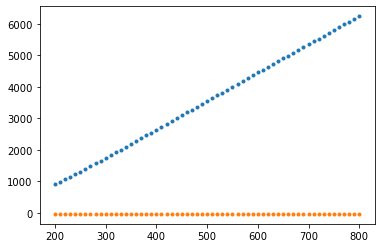

In [9]:
# Plotting
plt.figure
plt.plot(Start_Vel,BurnHeights,'.'),
plt.plot(Start_Vel,EndPos,'.')
yep=np.array(BurnHeights)-np.array(EndPos)
#plt.plot(Start_Vel,yep,'.');

## TEST USING CREATED DATA SETS

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Burn begins at height 2779 m (4.s.f), where rocket is travelling at speed 414.3 m/s (4.s.f).
Final height = -0.00083 m (2.s.f), where rocket is travelling at speed -0.07 m/s (2.s.f).
Mass of fuel used was 4212 kg (4.s.f), which was 68 % (2.s.f) of the remaining fuel (6164 kg (4.s.f)).


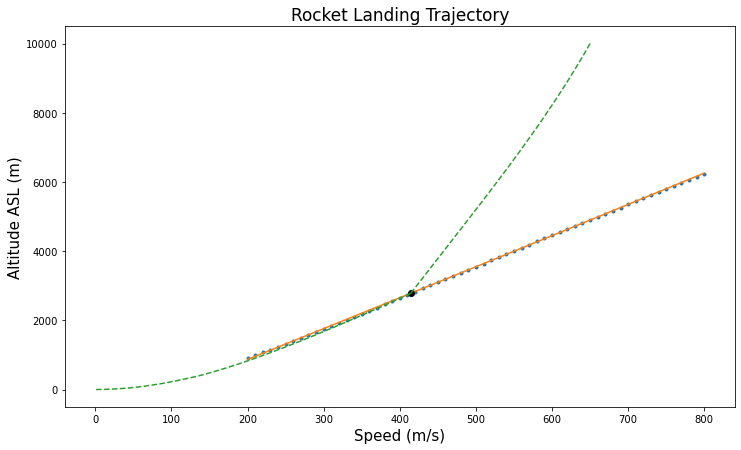

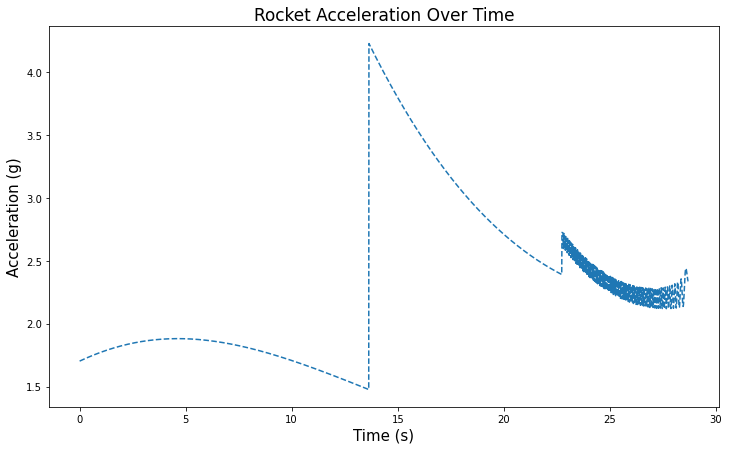

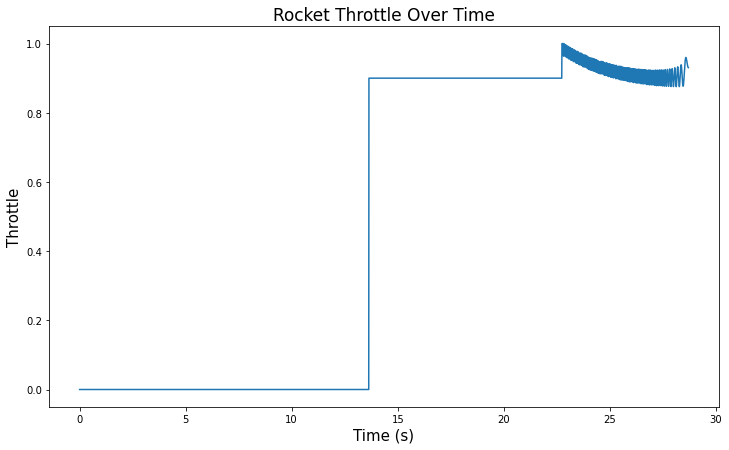

In [3]:
# Creating a canvas.
scene=canvas(width=800, height=400)
Ocean = box(pos=vector(0,-6,0),length=5000, height=10, width=5000, color=vector(0,0.8,1))

# Objects (based on 'just read the instructions' and falcon 9 full thrust block 5 first stage,
# all distances in METRES, ship deck is now 0M above/ocean level!)
# (https://en.wikipedia.org/wiki/Falcon_9_Full_Thrust#Rocket_specifications)

Ship = box(pos=vector(0,-3,0), length=90, width=50, height=6, color=vector(0.7,0.7,0.7))
Ship_yring = ring(pos=vector(0,-0.8,0),axis=vector(0,1,0), radius=10, thickness=1, color=vector(1,0.95,0))
Ship_wring = ring(pos=vector(0,-0.8,0),axis=vector(0,1,0), radius=18, thickness=1, color=vector(1,1,1))
Rocket= cylinder(axis=vector(0,42.6,0), radius=1.83, color=vector(0.9,0.9,0.9),make_trail=True,
                 trail_type="points",trail_radius=10)
scene.camera.follow(Rocket)

###############################################################################################
###############################################################################################

def Test(v,h,mfrac):
    g=9.81
    BurnTime=0.
    
    EmptyMass=22200
    LandingPercent=mfrac  #amount of first stage fuel left over for landing burn             
    InitFuel=(LandingPercent*410900)
    InitMass=EmptyMass+InitFuel

    ################################################################################################
    
    #####AIR RESISTANCE######
    #From wikipedia (dry air density) less than 18km approx, eventually incorporate humid!@@@
    p0=101325
    M=0.0289652
    R=8.31446
    T0=288.15
    L=0.0065
    X=(g*M)/(R*L)
    Cd=0.82                                       ##### estimate for cylinder drag coefficient 
    A=np.pi*(Rocket.radius)**2
    
    def CalcDrag(v,h):
        Pressure=p0*((1-(L*h)/T0))**X
        Density=(Pressure*M)/(R*(T0-L*h))
        Drag=0.5*Density*(v**2)*Cd*A
        return Drag

    def NetForce(v,h,Mass,Throttle):
        Force=CalcDrag(v,h)+(Throttle*850000)-(Mass*g)
        return Force
    def NetAcc(v,h,Mass,Throttle):
        Acc=NetForce(v,h,Mass,Throttle)/Mass
        return Acc
    ########################################################################## Fitting Start Height Curve
    plt.figure(figsize=(12,7))
    plt.title('Rocket Landing Trajectory', fontsize=17)
    plt.xlabel('Speed (m/s)', fontsize=15)
    plt.ylabel('Altitude ASL (m)', fontsize=15);

    y_heights, x_vel, y_final = np.loadtxt("Hoverslam DataBELOWTARGET.csv", delimiter=',')
    #SimpleCorrection=np.array(y_heights)-np.array(y_final)       #defo not correct to just subtract final from start height
    SimpleCorrection=np.array(y_heights)                    #need to normalise end heights but can't make close to 0 by subtracting^
    plt.plot(x_vel,SimpleCorrection,'.');
    fit=np.polyfit(x_vel,SimpleCorrection,2)
    x_test_values=np.linspace(200,800,5000)       #change if change range!!
    fitted_line = fit[0]*(x_test_values)**2+fit[1]*(x_test_values)+fit[2]   #quadratic fit?
    plt.plot(x_test_values,fitted_line,'-')                                 
    
    ### in list form
    fitted_line_list=fitted_line.tolist()
    
    ############################################## Code to find index (where in array) of value in fitted 
    # line x-values, which is most similar to rocket's speed --- then can find associated start height 
    # (using same index) needed to burn, from fitted line height array.
    
    def take_closest(myArr, myNumber):   
        index = np.searchsorted(myArr, myNumber, side='left')   #looks where value would be inserted into array to keep array order (AKA can be used to find nearest point around it)
        nearest_arr_index = index-1                #good approximation as long as enough values in line x-values (5000)
        return nearest_arr_index
    
    def RocketTOCurveDist(v,h):                 #finds closest x value in list as compared to rocket position
        closest_index = take_closest(x_test_values, -v)
        closest_height = fitted_line_list[closest_index]      #height of curve for closest speed value to rocket
        DistToBurn = h-closest_height                     #diff between rocket height and (closest speed) curve height
        return DistToBurn                                 # which AKA is predicted dist to burn

    def TESTFall(h,v,dt):
        DistToBurn=RocketTOCurveDist(v,h)
        h_1 = h + v * dt
        Acc=(CalcDrag(v,h)-(InitMass*g))/(InitMass)
        v_1 = v + Acc * dt      
        return h_1, v_1, DistToBurn, Acc

    def TESTanimateFall(h,v):
        # Setting the time step, and creating a time limit for the model.
        dt = 0.01                             
        time = 0.
        DistToBurn=1000                       #generic positive value to start loop
        
        #Will be used to plot path of rocket on speed/height graph, as it coincides with landing height curve
        Rocket_x_FALL=[]         
        Rocket_y_FALL=[]                   
        Rocket_time_FALL=[]                # Will plot acc vs time
        Rocket_acc_FALL=[]                 #
        while DistToBurn > 2:
            #print(f'Velocity={v}, Height={h}')
            rate(1/dt)
            Rocket_x_FALL.append(-v)
            Rocket_y_FALL.append(h)
            Rocket_time_FALL.append(time)
            h, v, DistToBurn,Acc = TESTFall(h, v, dt)      #either 1 or 2
            Rocket.pos = vector(0,h,0)
            Rocket_acc_FALL.append(Acc)
            time += dt
        return v,h,Rocket_x_FALL,Rocket_y_FALL,Rocket_time_FALL,Rocket_acc_FALL
    
    v, h, Rocket_x_FALL, Rocket_y_FALL,Rocket_time_FALL,Rocket_acc_FALL = TESTanimateFall(h,v)     #runs fall code
    Mass=InitMass
    
    #rounds and prints burn start values, and plots trajectory+intercept up to burn start.
    print(f'Burn begins at height {float(f"{h:.4g}"):g} m (4.s.f), where rocket is travelling' 
          f' at speed {float(f"{-v:.4g}"):g} m/s (4.s.f).')      
    plt.plot(-v,h,'ko')                                  #when rocket crosses curve
    plt.plot(np.array(Rocket_x_FALL),np.array(Rocket_y_FALL),'--')


    
    
    ########################################################## BURNING (USING START HEIGHT FROM GRAPH!!)
    Rocket.trail_color=vector(1,0,0)
    
    #Once burn starts, target is 20-40m below ground, predicted using 90% thrust, so need to
    #lift up target using throttleUpdate below, (this allows for/accounts for wind etc to 
    #raise target,as if aim for 0m, cannot drop target as even single engine too powerful 
    #at lowest thrust
    
    def ThrottleUpdate(v,h,Mass,Throttle,j):   #hard because of Throttle limits!!
        KE=0.5*Mass*v**2
        #KE equal to sum of work (Force x Dist) of drag, gravity and thrust(n x F x D)
        #so can rearrange to update throttle (n).
        #https://space.stackexchange.com/questions/51069/vertical-landing-calculating-
        #start-altitude-for-hoverslam-landing-burn   #included drag tho, also
        #is this right, surely all work's are added(plus?) as it is a scalar quantity?
        # this doesn't work tho as calculates const throttle at each step, doesn't predict in advance
        #instead try calc current predicted height needed to stop at throttle and then adjust
        pred_h=KE/(0.9*850000-Mass*g+CalcDrag(v,h))
        while pred_h<h and j==0:          #loops only used once, keeps at 0.9 for as long as poss?
            Throttle=0.9
            j=0                           # j used to never repeat loop after finishes once
            return Throttle,j
        
        j=1
        Throttle=Throttle+(pred_h-h)/1     #updates current throttle, smaller denoms are better,
        if Throttle>1:                     #but messier, this would be limited by throttle change speed
            Throttle=1                     # addition +ve or -ve depending on height diff   
        return Throttle,j

    def motionBurn(h,v,dt, Mass, Throttle,j):
        h_1 = h + v * dt
        Throttle,j=ThrottleUpdate(v,h,Mass, Throttle,j)
        #Throttle=0.9                           #Using 90% now, so can bring target up
        Thrust=Throttle*850000                          
        Acc=NetAcc(v,h,Mass,Throttle)
    #    print(f'Acceleration={Acc}')
        v_1 = v + Acc * dt
        return h_1, v_1, Acc, Throttle,j         #return acc just so can be plotted, not necessary

    def animationBurn(h,v):

        # Setting the time step, and creating a time limit for the model.
        Rocket.retain=1
        Rocket.trail_radius=5
        BurnTime=0.
        dt = 0.01                                                                                  
        time=0.
        Mass=InitMass
        Throttle=0.9
        j=0
        
        Rocket_x_BURN=[]
        Rocket_y_BURN=[]
        Rocket_time_BURN=[]
        Rocket_acc_BURN=[]
        Rocket_throttle_trace=[]
        
        while v<0 and h>=0:                     # and h>=0    #change if height of ship changes
    #        print(f'Velocity={v}, Height={h}')
            Rocket_x_BURN.append(-v)
            Rocket_y_BURN.append(h)
            Rocket_time_BURN.append(time)
            rate(1/dt)
            h, v, acc, Throttle,j = motionBurn(h, v, dt, Mass, Throttle,j)
            Rocket.pos = vector(0,h,0)
            Rocket_acc_BURN.append(acc)
            Rocket_throttle_trace.append(Throttle)
    #From https://space.stackexchange.com/questions/30497/does-anyone-know-
    #how-to-calculate-the-kg-per-second-of-rp-1-and-lox-from-the-9-m
    #not sure if correct tho hmmmm, what's the force?
            Thrust=Throttle*850000
            FuelRate=(Thrust)/(282*g)
            Mass=Mass-(dt*FuelRate)                      #should mass calc be before or after line 183, which requires mass?
            time += dt
            BurnTime += dt
        
        print(f'Final height = {float(f"{h:.2g}"):g} m (2.s.f), where rocket is travelling' 
          f' at speed {float(f"{-v:.2g}"):g} m/s (2.s.f).')             
        return h,v, Rocket_x_BURN,Rocket_y_BURN, Rocket_time_BURN, Rocket_acc_BURN, Rocket_throttle_trace, Mass  #'Rocket's' just for plotting
          
    h,v,Rocket_x_BURN,Rocket_y_BURN, Rocket_time_BURN, Rocket_acc_BURN,Rocket_throttle_trace, Mass = animationBurn(h,v)
    plt.plot(np.array(Rocket_x_BURN),np.array(Rocket_y_BURN),'--', color='#2CA02C')   #to plot rocket's path once started burning
    
    #now plotting acc vs time  (after, as plt.fig would disrupt other graph)
    plt.figure(figsize=(12,7))
    plt.title('Rocket Acceleration Over Time', fontsize=17)
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Acceleration (g)', fontsize=15);
    # time data
    Burn_start_time=Rocket_time_FALL[-1]   #final fall time
    Corrected_BURN_time=np.array(Rocket_time_BURN)+Burn_start_time    #so 0 for burn time = last for fall time
    del Rocket_time_FALL[-1]               #removing duplicate -- last of fall times = first of burn times
    Time_data = Rocket_time_FALL+(Corrected_BURN_time.tolist())       #combining time lists
    # acc data
    del Rocket_acc_FALL[-1]
    Acc_data = Rocket_acc_FALL+Rocket_acc_BURN
    Acc_data_2=np.array(Acc_data)/g
    # plot
    plt.plot(Time_data, Acc_data_2, '--')
    
    #now plotting Throttle vs time
    plt.figure(figsize=(12,7))
    plt.title('Rocket Throttle Over Time', fontsize=17)
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Throttle', fontsize=15)
    Extra_amount=len(Time_data)-len(Rocket_throttle_trace)
    Extra_throttles=(np.linspace(0,0,Extra_amount)).tolist()
    Rocket_throttle_data=Extra_throttles+Rocket_throttle_trace
    plt.plot(Time_data, Rocket_throttle_data, '-')
    
    #Calculting fuel/mass statistics
    Fuel_used=InitMass-Mass
    Fuel_used_perc=(Fuel_used/InitFuel)*100
        
    print(f'Mass of fuel used was {float(f"{Fuel_used:.4g}"):g} kg (4.s.f), which was {float(f"{Fuel_used_perc:.2g}"):g} %'
         f' (2.s.f) of the remaining fuel ({float(f"{InitFuel:.4g}"):g} kg (4.s.f)).')
          
Test(-650,10000,0.015)          
#using data points from range x=25-50 means rocket should always stop above platform, so can adjust throttle to touchdown.
#will use 100% then decrease, but could aim for below and use 0.9, then increase (as engines are too powerful, cannot drop).